## Project : Cell image segmentation projects

Contact: Elena Casiraghi (University Milano elena.casiraghi@unimi.it)

Cell segmentation is usually the first step for downstream single-cell analysis in microscopy image-based biology and biomedical research. Deep learning has been widely used for cell-image segmentation.
The CellSeg competition aims to benchmark cell segmentation methods that could be applied to various microscopy images across multiple imaging platforms and tissue types for cell Segmentation. The  Dataset challenge organizers provide both labeled images and unlabeled ones.
The “2018 Data Science Bowl” Kaggle competition provides cell images and their masks for training cell/nuclei segmentation models.

In 2022 another [Cell Segmentation challenge was proposed at Neurips](https://neurips22-cellseg.grand-challenge.org/).
For interested readers, the competition proceeding has been published on [PMLR](https://proceedings.mlr.press/v212/)

### Project Description

In the field of (bio-medical) image processing, segmentation of images is typically performed via U-Nets [1,2].

A U-Net consists of an encoder - a series of convolution and pooling layers which reduce the spatial resolution of the input, followed by a decoder - a series of transposed convolution and upsampling layers which increase the spatial resolution of the input. The encoder and decoder are connected by a bottleneck layer which is responsible for reducing the number of channels in the input.
The key innovation of U-Net is the addition of skip connections that connect the contracting path to the corresponding layers in the expanding path, allowing the network to recover fine-grained details lost during downsampling.

<img src='https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png' width="400"/>


At this [link](https://rpubs.com/eR_ic/unet), you find an R implementation of basic U-Nets. At this [link](https://github.com/zhixuhao/unet), you find a Keras implementation of UNets.  
Other implementations of more advanced UNets are also made available in [2] at these links: [UNet++](https://github.com/MrGiovanni/UNetPlusPlus)
and by the CellSeg organizers as baseline models: [https://neurips22-cellseg.grand-challenge.org/baseline-and-tutorial/](https://neurips22-cellseg.grand-challenge.org/baseline-and-tutorial/)


### Project aim

The aim of the project is to download the *gray-level* (.tiff or .tif files) cell images from the [CellSeg](https://neurips22-cellseg.grand-challenge.org/dataset/) competition and assess the performance of an UNet or any other Deep model for cell segmentation.
We suggest using gray-level images to obtain a model that is better specified on a sub class of images.

Students are not restricted to use UNets but may other model is wellcome; e.g., even transformer based model in the [leaderboard](https://neurips22-cellseg.grand-challenge.org/evaluation/testing/leaderboard/) may be tested.
Students are free to choose any model, as long as they are able to explain their rationale, architecture, strengths and weaknesses.



### References

[1] Ronneberger, O., Fischer, P., Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. In: Navab, N., Hornegger, J., Wells, W., Frangi, A. (eds) Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015. MICCAI 2015. Lecture Notes in Computer Science(), vol 9351. Springer, Cham. https://doi.org/10.1007/978-3-319-24574-4_28

[2] Long, F. Microscopy cell nuclei segmentation with enhanced U-Net. BMC Bioinformatics 21, 8 (2020). https://doi.org/10.1186/s12859-019-3332-1


## Initialization

In [95]:
!pip install --upgrade gdown
!pip install torch
!pip install torchvision
!pip install opencv-contrib-python
!pip install torchsummary

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import tempfile
from typing import Callable, List, Tuple
from torchvision import transforms
from PIL import Image

In [97]:
TRAIN_PATH = 'data_train/Training-labeled/images/'
TRAIN_LABELS_PATH = 'data_train/Training-labeled/labels/'

TEST_PATH = 'data_test/Testing/Public/images/'
TEST_LABELS_PATH = 'data_test/Testing/Public/labels/'

VAL_PATH = 'data_val/Tuning/images/'
VAL_LABELS_PATH = 'data_val/Tuning/labels/'

use_cuda = torch.cuda.is_available()
if use_cuda:
  device = torch.device("cuda")
  dataloader_kwargs = {"batch_size": 5, "shuffle": True, "pin_memory": False}
else:
  device = torch.device("cpu")
  dataloader_kwargs = {"batch_size": 64}


### Data preparation
[Browse the data](https://drive.google.com/drive/folders/1MaJibsHYitCPOltxVzYjr3rm5s9Vpjpv)

In [98]:
!curl -o data_test.zip "https://zenodo.org/records/10719375/files/Testing.zip?download=1"
!unzip -d data_test data_test.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2793M  100 2793M    0     0  22.1M      0  0:02:06  0:02:06 --:--:-- 22.2M
Archive:  data_test.zip
replace data_test/Testing/Hidden/images/TestHidden_214.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data_test/Testing/Hidden/images/TestHidden_214.tif  
  inflating: data_test/Testing/Hidden/images/TestHidden_224.tif  
  inflating: data_test/Testing/Hidden/images/TestHidden_222.tif  
  inflating: data_test/Testing/Hidden/images/TestHidden_049.png  
  inflating: data_test/Testing/Hidden/images/TestHidden_161.tif  
  inflating: data_test/Testing/Hidden/images/TestHidden_040.tiff  
  inflating: data_test/Testing/Hidden/images/TestHidden_003.tif  
  inflating: data_test/Testing/Hidden/images/TestHidden_038.tif  
  inflating: data_test/Testing/Hidden/images/TestHidden_073.tif  
  inflating: data_test/Testing/Hidden/images

In [99]:
!curl -o data_train.zip "https://zenodo.org/records/10719375/files/Training-labeled.zip?download=1"
!unzip -d data_train data_train.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1926M  100 1926M    0     0  23.9M      0  0:01:20  0:01:20 --:--:-- 24.7M
Archive:  data_train.zip
replace data_train/Training-labeled/labels/cell_00504_label.tiff? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data_train/Training-labeled/labels/cell_00504_label.tiff  
  inflating: data_train/Training-labeled/labels/cell_00530_label.tiff  
  inflating: data_train/Training-labeled/labels/cell_00515_label.tiff  
  inflating: data_train/Training-labeled/labels/cell_00552_label.tiff  
  inflating: data_train/Training-labeled/labels/cell_00517_label.tiff  
  inflating: data_train/Training-labeled/labels/cell_00642_label.tiff  
  inflating: data_train/Training-labeled/labels/cell_00630_label.tiff  
  inflating: data_train/Training-labeled/labels/cell_00511_label.tiff  
  inflating: data_train/Training-labeled/labels/cell_005

In [100]:
!curl -o data_val.zip "https://zenodo.org/records/10719375/files/Tuning.zip?download=1"
!unzip -d data_val data_val.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  595M  100  595M    0     0  22.9M      0  0:00:25  0:00:25 --:--:-- 24.3M
Archive:  data_val.zip
replace data_val/Tuning/images/cell_00101.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data_val/Tuning/images/cell_00101.tif  
  inflating: data_val/Tuning/images/cell_00026.png  
  inflating: data_val/Tuning/images/cell_00063.png  
  inflating: data_val/Tuning/images/cell_00065.png  
  inflating: data_val/Tuning/images/cell_00099.tif  
  inflating: data_val/Tuning/images/cell_00054.png  
  inflating: data_val/Tuning/images/cell_00064.png  
  inflating: data_val/Tuning/images/cell_00047.png  
  inflating: data_val/Tuning/images/cell_00066.png  
  inflating: data_val/Tuning/images/cell_00058.png  
  inflating: data_val/Tuning/images/cell_00045.png  
  inflating: data_val/Tuning/images/cell_00048.png  
  inflating: data

In [101]:
class PadToSquare:
    def __init__(self, size=512, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, img):
        w, h = img.size

        max_dim = max(w, h)
        pad_w = (max_dim - w) // 2
        pad_h = (max_dim - h) // 2

        padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
        img = transforms.functional.pad(img, padding, fill=self.fill)

        img = transforms.functional.resize(img, (self.size, self.size))
        return img

class ToBinary:
    """
    Converts a PIL image whose pixels are {0,1,2,…}
    into a 1-channel float tensor in {0.,1.}.
    Works after PadToSquare.
    """
    def __call__(self, img):
        arr = np.array(img)
        binary = (arr > 0).astype(np.float32)   # 0/1
        tensor = torch.from_numpy(binary)[None]
        return tensor

class ConvertToGrayscale:
    """
    Custom grayscale converter that handles images with any number of channels,
    including RGBA (4 channels) where the alpha channel contains the actual data.
    """
    def __call__(self, img):
        arr = np.array(img)

        if len(arr.shape) == 2:
            if arr.dtype == np.uint16 or arr.dtype == np.int16:
                arr = ((arr.astype(np.float32) - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
                return Image.fromarray(arr, mode='L')
            return img
        elif arr.shape[2] == 1:
            return img
        elif arr.shape[2] == 3:
            return transforms.functional.rgb_to_grayscale(img)
        elif arr.shape[2] == 4:
            alpha_channel = arr[:, :, 3]

            if alpha_channel.dtype in [np.uint16, np.int16]:
                alpha_channel = ((alpha_channel.astype(np.float32) - alpha_channel.min()) /
                                (alpha_channel.max() - alpha_channel.min()) * 255).astype(np.uint8)
            elif alpha_channel.dtype != np.uint8:
                if alpha_channel.dtype in [np.float32, np.float64]:
                    alpha_channel = (alpha_channel * 255).astype(np.uint8)
                else:
                    alpha_channel = np.clip(alpha_channel, 0, 255).astype(np.uint8)

            grayscale_img = Image.fromarray(alpha_channel, mode='L')
            return grayscale_img
        else:
            raise ValueError(f"Unexpected number of channels: {arr.shape[2]}")

# Partially adapted from https://colab.research.google.com/github/mim-ml-teaching/public-dnn-2024-25/blob/master/docs/DNN-Lab-7-UNet-in-Pytorch-student-version.ipynb
class ImageTiffDataset(torch.utils.data.Dataset):
  def __init__(self,
               image_dir: str,
               target_dir: str,
               cache_dir: str,
               file_pairs: List[Tuple[str, str]],
               transform: torch.nn.Module = transforms.ToTensor(),
               target_transform: torch.nn.Module = transforms.ToTensor()):
    self.image_dir = image_dir
    self.target_dir = target_dir
    self.cache_dir = cache_dir
    self.file_pairs = file_pairs

    self.transform = transforms.Compose([
        PadToSquare(size=512),
        ConvertToGrayscale(),
        transforms.ToTensor(),
    ])
    self.target_transform = transforms.Compose([
        PadToSquare(size=512, fill=0),
        ToBinary(),
        #transforms.Grayscale(num_output_channels=1),
        #transforms.ToTensor(),
    ])

    if not os.path.exists(self.cache_dir):
      os.mkdir(self.cache_dir)
      os.mkdir(os.path.join(self.cache_dir, "images"))
      os.mkdir(os.path.join(self.cache_dir, "target"))


  def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
    img_filename, target_filename = self.file_pairs[idx]

    img_path = os.path.join(self.image_dir, img_filename)
    target_path = os.path.join(self.target_dir, target_filename)
    img_cache = os.path.join(self.cache_dir, img_filename)
    target_cache = os.path.join(self.cache_dir, target_filename)

    if not os.path.exists(img_cache):
      # Change. I had this error: AttributeError: module 'PIL.Image' has no attribute 'load'
      #img = Image.load(img_path)
      # End of change
      img = Image.open(img_path)
      img = self.transform(img)
      torch.save(img, img_cache)
    else:
      img = torch.load(img_cache)

    if not os.path.exists(target_cache):
      # Change. I had this error: AttributeError: module 'PIL.Image' has no attribute 'load'
      #target = Image.load(target_path)
      target = Image.open(target_path)
      # End of change
      target = self.target_transform(target)
      torch.save(target, target_cache)
    else:
      target = torch.load(target_cache)

    return img, target

  def __len__(self) -> int:
    return len(self.file_pairs)

def is_valid_tiff(path):
    try:
        with Image.open(path) as img:
            img.verify()
        return True
    except:
        return False

def find_image_mask_pairs(images_dir, masks_dir):
    print(f"Searching in {images_dir} and {masks_dir}")
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.tiff') or f.endswith('.tif')]
    mask_files = set(f for f in os.listdir(masks_dir) if f.endswith('.tiff') or f.endswith('.tif'))

    pairs = []
    for img_file in image_files:
        #if (len(pairs) > 10): break DELETING
        base_name = img_file[:-5] if img_file.endswith('.tiff') else img_file[:-4]

        found = False
        for suffix in ['_label.tiff', '_label.tif']:
            candidate_mask = base_name + suffix
            if candidate_mask in mask_files:
                img_path = os.path.join(images_dir, img_file)
                mask_path = os.path.join(masks_dir, candidate_mask)
                if is_valid_tiff(img_path) and is_valid_tiff(mask_path):
                    pairs.append((img_file, candidate_mask))
                else:
                    print(f"Invalid file: {img_file} or {candidate_mask}")
                found = True
                break

        if not found:
            print(f"No mask for image {img_file}")

    return pairs

def make_tiff_dataset(image_dir: str, target_dir: str, cache_dir: str):
    file_pairs = find_image_mask_pairs(image_dir, target_dir)
    return ImageTiffDataset(image_dir, target_dir, cache_dir, file_pairs)

In [102]:
train_dataset = make_tiff_dataset(TRAIN_PATH, TRAIN_LABELS_PATH, tempfile.mkdtemp())
test_dataset = make_tiff_dataset(TEST_PATH, TEST_LABELS_PATH, tempfile.mkdtemp())
val_dataset = make_tiff_dataset(VAL_PATH, VAL_LABELS_PATH, tempfile.mkdtemp())
dataloader_train = torch.utils.data.DataLoader(train_dataset, **dataloader_kwargs)
dataloader_test = torch.utils.data.DataLoader(test_dataset, **dataloader_kwargs)
dataloader_val = torch.utils.data.DataLoader(val_dataset, **dataloader_kwargs)

print('Train:', len(train_dataset))
print('Test:', len(test_dataset))
print('Val:', len(val_dataset))

Searching in data_train/Training-labeled/images/ and data_train/Training-labeled/labels/
Invalid file: cell_00503.tif or cell_00503_label.tiff
Invalid file: cell_00501.tif or cell_00501_label.tiff
Invalid file: cell_00309.tiff or cell_00309_label.tiff
Invalid file: cell_00305.tiff or cell_00305_label.tiff
Invalid file: cell_00507.tif or cell_00507_label.tiff
Invalid file: cell_00502.tif or cell_00502_label.tiff
Invalid file: cell_00303.tiff or cell_00303_label.tiff
Invalid file: cell_00306.tiff or cell_00306_label.tiff
Invalid file: cell_00313.tiff or cell_00313_label.tiff
Invalid file: cell_00312.tiff or cell_00312_label.tiff
Invalid file: cell_00505.tif or cell_00505_label.tiff
Invalid file: cell_00307.tiff or cell_00307_label.tiff
Invalid file: cell_00308.tiff or cell_00308_label.tiff
Invalid file: cell_00311.tiff or cell_00311_label.tiff
Invalid file: cell_00316.tiff or cell_00316_label.tiff
Invalid file: cell_00506.tif or cell_00506_label.tiff
Invalid file: cell_00302.tiff or cell

## Basic UNet (UNet_1) from https://rpubs.com/eR_ic/unet

In [103]:
import torch
import torch.nn as nn
import torchvision.transforms.functional

# Implement the double 3X3 convolution blocks
# The original paper did not use padding, but we will use padding to keep the image size the same

class double_convolution(nn.Module):
    """
    This class implements the double convolution block which consists of two 3X3 convolution layers,
    each followed by a ReLU activation function.

    """
    def __init__(self, in_channels, out_channels): # Initialize the class
        super().__init__() # Initialize the parent class

        # First 3X3 convolution layer
        self.first_cnn = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        self.act1 = nn.ReLU()

        # Second 3X3 convolution layer
        self.second_cnn = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        self.act2 = nn.ReLU()

    # Pass the input through the double convolution block
    def forward(self, x):
        x = self.first_cnn(x)
        x = self.act1(x)
        x = self.act2(self.second_cnn(x))
        return x


# Implement the Downsample block that occurs after each double convolution block
class down_sample(nn.Module):
    """
    This class implements the downsample block which consists of a Max Pooling layer with a kernel size of 2.
    The Max Pooling layer halves the image size reducing the spatial resolution of the feature maps
    while retaining the most important features.
    """
    def __init__(self):
        super().__init__()
        self.max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

    # Pass the input through the downsample block
    def forward(self, x):
        x = self.max_pool(x)
        return x

# Implement the UpSample block that occurs in the decoder part of the network
class up_sample(nn.Module):
    """
    This class implements the upsample block which consists of a convolution transpose layer with a kernel size of 2.
    The convolution transpose layer doubles the image size increasing the spatial resolution of the feature maps
    while retaining the learned features.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Convolution transpose layer
        self.up_sample = nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 2, stride = 2)

    # Pass the input through the upsample block
    def forward(self, x):
        x = self.up_sample(x)
        return x

# Implement the crop and concatenate block that occurs in the decoder part of the network
# This block concatenates the output of the upsample block with the output of the corresponding downsample block
# The output of the crop and concatenate block is then passed through a double convolution block
class crop_and_concatenate(nn.Module):
    """
    This class implements the crop and concatenate block which combines the output of the upsample block
    with the corresponding features from the contracting path through skip connections,
    allowing the network to recover the fine-grained details lost during downsampling
    and produce a high-resolution output segmentation map.
    """
    # def forward(self, upsampled, bypass):
    #     # Crop the feature map from the contacting path to match the size of the upsampled feature map
    #     bypass = torchvision.transforms.functional.center_crop(img = bypass, output_size = [upsampled.shape[2], upsampled.shape[3]])
    #     # Concatenate the upsampled feature map with the cropped feature map from the contracting path
    #     x = torch.cat([upsampled, bypass], dim = 1) # Concatenate along the channel dimension
    #     return x
    # Alternatively crop the upsampled feature map to match the size of the feature map from the contracting path
    def forward(self, upsampled, bypass):
        upsampled = torchvision.transforms.functional.resize(img = upsampled, size = bypass.shape[2:], antialias=True)
        x = torch.cat([upsampled, bypass], dim = 1) # Concatenate along the channel dimension
        return x

# m = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
# input = torch.randn(1, 1024, 28, 28)
# m(input).shape

# m = nn.MaxPool2d(kernel_size = 2, stride = 2)
# xx = torch.randn(1, 1, 143, 143)
# m(xx).shape

## Implement the UNet architecture
class UNet(nn.Module):
    # in_channels: number of channels in the input image
    # out_channels: number of channels in the output image
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Define the contracting path: convolution blocks followed by downsample blocks
        self.down_conv = nn.ModuleList(double_convolution(in_chans, out_chans) for in_chans, out_chans in
                                       [(in_channels, 64), (64, 128), (128, 256), (256, 512)]) # List of downsample blocks

        self.down_samples = nn.ModuleList(down_sample() for _ in range(4))

        # Define the bottleneck layer
        self.bottleneck = double_convolution(in_channels = 512, out_channels = 1024)

        # Define the expanding path: upsample blocks followed by convolution blocks
        self.up_samples = nn.ModuleList(up_sample(in_chans, out_chans) for in_chans, out_chans in
                                        [(1024, 512), (512, 256), (256, 128), (128, 64)]) # List of upsample blocks

        self.concat = nn.ModuleList(crop_and_concatenate() for _ in range(4))

        self.up_conv = nn.ModuleList(double_convolution(in_chans, out_chans) for in_chans, out_chans in
                                        [(1024, 512), (512, 256), (256, 128), (128, 64)]) # List of convolution blocks

        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv = nn.Conv2d(in_channels = 64, out_channels = out_channels, kernel_size = 1)

    # Pass the input through the UNet architecture
    def forward(self, x):
        # Pass the input through the contacting path
        skip_connections = [] # List to store the outputs of the downsample blocks
        for down_conv, down_sample in zip(self.down_conv, self.down_samples):
            x = down_conv(x)
            skip_connections.append(x)
            x = down_sample(x)

        # Pass the output of the contacting path through the bottleneck layer
        x = self.bottleneck(x)

        # Pass the output of the bottleneck layer through the expanding path
        skip_connections = skip_connections[::-1] # Reverse the list of skip connections
        for up_sample, concat, up_conv in zip(self.up_samples, self.concat, self.up_conv):
            x = up_sample(x)
            x = concat(x, skip_connections.pop(0)) # Remove the first element from the list of skip connections
            x = up_conv(x)

        # Pass the output of the expanding path through the final convolution layer
        x = self.final_conv(x)
        return x

## ResidualAttentionUnet (UNet_2) from https://rpubs.com/eR_ic/unet

In [104]:
import torch
import torch.nn as nn
import torchvision

# Define a Residual block
class residual_block(nn.Module):
    """
    This class implements a residual block which consists of two convolution layers with group normalization
    """
    def __init__(self, in_channels, out_channels, n_groups = 8):
        super().__init__()
        # First convolution layer
        self.first_conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        self.first_norm = nn.GroupNorm(num_groups = n_groups, num_channels = out_channels)
        self.act1 = nn.SiLU() # Swish activation function

        # Second convolution layer
        self.second_conv = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        self.second_norm = nn.GroupNorm(num_groups = n_groups, num_channels = out_channels)
        self.act2 = nn.SiLU() # Swish activation function

        # If the number of input channels is not equal to the number of output channels,
        # then use a 1X1 convolution layer to compensate for the difference in dimensions
        # This allows the input to have the same dimensions as the output of the residual block
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1)
        else:
            # Pass the input as is
            self.shortcut = nn.Identity()

    # Pass the input through the residual block
    def forward(self, x):
        # Store the input
        input = x

        # Pass input through the first convolution layer
        x = self.act1(self.second_norm(self.first_conv(x)))

        # Pass the output of the first convolution layer through the second convolution layer
        x = self.act2(self.second_norm(self.second_conv(x)))

        # Add the input to the output of the second convolution layer
        # This is the skip connection
        x = x + self.shortcut(input)
        return x

# Implement the DownSample block that occurs after each residual block
class down_sample(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

    # Pass the input through the downsample block
    def forward(self, x):
        x = self.max_pool(x)
        return x

# Implement the UpSample block that occurs in the decoder path/expanding path
class up_sample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Convolution transpose layer to upsample the input
        self.up_sample = nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 2, stride = 2)

    # Pass the input through the upsample block
    def forward(self, x):
        x = self.up_sample(x)
        return x

# Implement the crop and concatenate layer
class crop_and_concatenate(nn.Module):
    def forward(self, upsampled, bypass):
        # Crop the upsampled feature map to match the dimensions of the bypass feature map
        upsampled = torchvision.transforms.functional.resize(upsampled, size = bypass.shape[2:], antialias=True)
        x = torch.cat([upsampled, bypass], dim = 1) # Concatenate along the channel dimension
        return x

# Implement an attention block
class attention_block(nn.Module):
    def __init__(self, skip_channels, gate_channels, inter_channels = None, n_groups = 8):
        super().__init__()

        if inter_channels is None:
            inter_channels = skip_channels // 2

        # Implement W_g i.e the convolution layer that operates on the gate signal
        # Upsample gate signal to be the same size as the skip connection
        self.W_g = up_sample(in_channels = gate_channels, out_channels = skip_channels)
        #self.W_g_norm = nn.GroupNorm(num_groups = n_groups, num_channels = skip_channels)
        #self.W_g_act = nn.SiLU() # Swish activation function

        # Implement W_x i.e the convolution layer that operates on the skip connection
        self.W_x = nn.Conv2d(in_channels = skip_channels, out_channels = inter_channels, kernel_size = 1)
        #self.W_x_norm = nn.GroupNorm(num_groups = n_groups, num_channels = inter_channels)
        #self.W_x_act = nn.SiLU() # Swish activation function

        # Implement phi i.e the convolution layer that operates on the output of W_x + W_g
        self.phi = nn.Conv2d(in_channels = inter_channels, out_channels = 1, kernel_size = 1)
        #self.phi_norm = nn.GroupNorm(num_groups = n_groups, num_channels = 1)
        #self.phi_act = nn.SiLU() # Swish activation function

        # Implement the sigmoid activation function
        self.sigmoid = nn.Sigmoid()
        # Implement the Swish activation function
        self.act = nn.SiLU()

        # Implement final group normalization layer
        self.final_norm = nn.GroupNorm(num_groups = n_groups, num_channels = skip_channels)

        # Add the final 1x1 convolution layer here in __init__
        self.final_conv = nn.Conv2d(in_channels = skip_channels, out_channels = skip_channels, kernel_size = 1)

    # Pass the input through the attention block
    def forward(self, skip_connection, gate_signal):
        # Upsample the gate signal to match the channels of the skip connection
        gate_signal = self.W_g(gate_signal)
        # Ensure that the sizes of the skip connection and the gate signal match before addition
        if gate_signal.shape[2:] != skip_connection.shape[2:]:
            gate_signal = torchvision.transforms.functional.resize(gate_signal, size = skip_connection.shape[2:], antialias=True)
        # Project to the intermediate channels
        gate_signal = self.W_x(gate_signal)

        # Project the skip connection to the intermediate channels
        skip_signal = self.W_x(skip_connection)

        # Add the skip connection and the gate signal
        add_xg = gate_signal + skip_signal

        # Pass the output of the addition through the activation function
        add_xg = self.act(add_xg)

        # Pass the output of attention through a 1x1 convolution layer to obtain the attention map
        attention_map = self.sigmoid(self.phi(add_xg))

        # Multiply the skip connection with the attention map
        # Perform element-wise multiplication
        skip_connection = torch.mul(skip_connection, attention_map)

        # Use the pre-defined convolution layer instead of creating a new one
        skip_connection = self.final_conv(skip_connection)
        skip_connection = self.act(self.final_norm(skip_connection))

        return skip_connection

## Implement a residual attention U-Net
class ResidualAttentionUnet(nn.Module):
    def __init__(self, in_channels, out_channels, n_groups = 4, n_channels = [64, 128, 256, 512, 1024]):
        super().__init__()

        # Define the contracting path: residual blocks followed by downsampling
        self.down_conv = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                       [(in_channels, n_channels[0]), (n_channels[0], n_channels[1]), (n_channels[1], n_channels[2]), (n_channels[2], n_channels[3])])
        self.down_samples = nn.ModuleList(down_sample() for _ in range(4))

        # Define the bottleneck residual block
        self.bottleneck = residual_block(n_channels[3], n_channels[4])

        # Define the attention blocks
        self.attention_blocks = nn.ModuleList(attention_block(skip_channels = residuals_chans, gate_channels = gate_chans) for gate_chans, residuals_chans in
                                              [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])

        # Define the expanding path: upsample blocks, followed by crop and concatenate, followed by residual blocks
        self.upsamples = nn.ModuleList(up_sample(in_chans, out_chans) for in_chans, out_chans in
                                       [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])

        self.concat = nn.ModuleList(crop_and_concatenate() for _ in range(4))

        self.up_conv = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                     [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])

        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv = nn.Conv2d(in_channels = n_channels[0] , out_channels = out_channels, kernel_size = 1)

    # Pass the input through the residual attention U-Net
    def forward(self, x):
        # Store the skip connections
        skip_connections = []
        # # Store the gate signals
        # gate_signals = []

        # Pass the input through the contracting path
        for down_conv, down_sample in zip(self.down_conv, self.down_samples):
            x = down_conv(x)
            skip_connections.append(x)
            #gate_signals.append(x)
            x = down_sample(x)

        # Pass the output of the contracting path through the bottleneck
        x = self.bottleneck(x)
        skip_connections.append(x)

        # Attention on the residual connections
        #skip_connections = skip_connections[::-1]
        n = len(skip_connections)
        indices = [(n - 1 - i, n - 2 - i) for i in range(n - 1)]
        attentions = []
        for i, g_x in enumerate(indices):
            g_gate = g_x[0]
            x_residual = g_x[1]
            attn = self.attention_blocks[i](skip_connections[x_residual], skip_connections[g_gate])
            attentions.append(attn)

        #attentions = attentions[::-1]

        # Pass the output of the attention blocks through the expanding path
        for up_sample, concat, up_conv in zip(self.upsamples, self.concat, self.up_conv):
            x = up_sample(x)
            x = concat(x, attentions.pop(0))
            x = up_conv(x)

        # Pass the output of the expanding path through the final convolution layer
        x = self.final_conv(x)
        return x

## Training and Testing both models


In [105]:
import torch
import torch.nn as nn
import numpy as np
from scipy.ndimage import label as cc

THRESHOLD2 = 0.4

class DiceLoss(torch.nn.Module):
    def __init__(self, smooth: float = 1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        probs = torch.sigmoid(logits)
        num = 2 * (probs * targets).sum(dim=(1,2,3)) + self.smooth
        denom = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + self.smooth
        dice = 1 - num / denom
        return dice.mean()

def _np(x):
    return x.detach().cpu().numpy() if torch.is_tensor(x) else x

def iou_bin(pred, gt, eps=1e-6):
    pred, gt = _np(pred) > 0, _np(gt) > 0
    inter = (pred & gt).sum()
    union = (pred | gt).sum()
    return (inter + eps) / (union + eps)

def rand_error(pred, gt):
    p = _np(pred).astype(np.int64).ravel()
    g = _np(gt).astype(np.int64).ravel()
    n = len(p)
    k = max(p.max(), g.max()) + 1
    table = np.zeros((k, k), dtype=np.int64)
    for pi, gi in zip(p, g):
        table[pi, gi] += 1
    comb2 = lambda x: x * (x - 1) // 2
    a = comb2(table).sum()
    b = comb2(table.sum(0)).sum() + comb2(table.sum(1)).sum() - 2 * a
    rand_idx = (a + (comb2(n) - b - a)) / comb2(n)
    return 1.0 - rand_idx

def warping_error(pred, gt):
    pred, gt = _np(pred), _np(gt)
    n_gt = len(np.unique(gt)) - 1
    if n_gt == 0:
        return 0.0

    splits = 0
    for gid in np.unique(gt):
        if gid == 0:
            continue
        overlap = np.unique(pred[gt == gid])
        overlap = overlap[overlap != 0]
        splits += max(0, len(overlap) - 1)
    merges = 0
    for pid in np.unique(pred):
        if pid == 0:
            continue
        overlap = np.unique(gt[pred == pid])
        overlap = overlap[overlap != 0]
        merges += max(0, len(overlap) - 1)

    return (splits + merges) / n_gt

def _components(mask):
    mask = _np(mask)
    if mask.max() <= 1:
        mask, n = cc(mask.astype(np.uint8))
    else:
        n = mask.max()
    return [(mask == i) for i in range(1, n + 1)]

def ap50(pred_mask, logits, gt_mask, thr=THRESHOLD2):
    pred_bin = (torch.sigmoid(logits) > thr).squeeze(1)
    pred_inst = _components(pred_bin)
    gt_inst = _components(gt_mask)

    scores = [logits[inst].sigmoid().mean().item() for inst in pred_inst]

    tp = np.zeros(len(pred_inst), dtype=bool)
    used = set()
    for i, inst in enumerate(pred_inst):
        best_iou, best_j = 0.0, None
        for j, gt in enumerate(gt_inst):
            if j in used: continue
            inter = np.logical_and(inst, gt).sum()
            union = np.logical_or(inst, gt).sum()
            iou = inter / union if union else 0.0
            if iou > best_iou:
                best_iou, best_j = iou, j
        tp[i] = best_iou >= 0.5
        if tp[i]: used.add(best_j)

    order = np.argsort(scores)[::-1]
    tp = tp[order].cumsum()
    fp = (~tp.astype(bool))[order].cumsum()
    rec = tp / (len(gt_inst) or 1)
    prec = tp / (tp + fp + 1e-9)
    ap = np.mean([prec[rec >= r].max() if (rec >= r).any() else 0
                  for r in np.linspace(0, 1, 11)])
    return ap

def train(model, device, train_loader, optimizer, epoch, log_interval, threshold=THRESHOLD2):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total_pixels = 0

    weight_criterion = 0.5
    weight_dice = 1 - weight_criterion

    fg, tot = 0, 0
    max_batches = 50
    for i, (_, y) in enumerate(train_loader):
        fg += y.sum().item()
        tot += y.numel()
        if fg > 0 or i >= max_batches:
            break

    pos_frac = fg / tot if fg > 0 else 1e-6
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([(1 - pos_frac) / pos_frac], device=device))
    dice = DiceLoss()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device).float(), target.to(device).float()

        optimizer.zero_grad()
        output = model(data)

        loss = weight_dice * dice(output, target) + weight_criterion * criterion(output, target)
        loss.backward()
        optimizer.step()

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        running_loss += loss.item() * data.size(0)

        preds = (torch.sigmoid(output) > threshold).float()
        running_correct += (preds == target).sum().item()
        total_pixels += torch.numel(target)

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                  f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100. * running_correct / total_pixels
    print(f"Train Epoch: {epoch} Average loss: {epoch_loss:.6f}, Accuracy: {epoch_acc:.2f}%")

def test(model, device, test_loader, print_ap=True):
    model.eval()
    test_loss = 0.0
    correct = 0
    total_pixels = 0

    TP = 0
    FP = 0
    FN = 0

    sum_iou = 0
    rand_err = 0
    warp_err = 0
    ap_sum, ap_imgs = 0, 0

    fg, tot = 0, 0
    max_batches = 50
    for i, (_, y) in enumerate(test_loader):
        fg += y.sum().item()
        tot += y.numel()
        if fg > 0 or i >= max_batches:
            break

    pos_frac = fg / tot if fg > 0 else 1e-6
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([(1 - pos_frac) / pos_frac], device=device))
    dice = DiceLoss()

    weight_criterion = 0.5
    weight_dice = 1 - weight_criterion

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device).float(), target.to(device).float()

            output = model(data)
            loss = weight_dice * dice(output, target) + weight_criterion * criterion(output, target)
            test_loss += loss.item() * data.size(0)

            preds = (torch.sigmoid(output) > 0.5).float()
            correct += (preds == target).sum().item()
            total_pixels += torch.numel(target)

            TP += (preds * target).sum().item()
            FP += (preds * (1 - target)).sum().item()
            FN += ((1 - preds) * target).sum().item()

            for p, g, log in zip(preds, target, output):
                sum_iou += iou_bin(p, g)
                rand_err += rand_error(p, g.long())
                warp_err += warping_error(p.long(), g.long())
                if print_ap:
                    ap_sum += ap50(p.cpu().numpy(), log.cpu(), g.cpu().numpy())
                    ap_imgs += 1

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / total_pixels

    n_img = len(test_loader.dataset)
    smooth = 1e-6
    recall = TP / (TP + FN + smooth)
    precision = TP / (TP + FP + smooth)
    f1 = 2 * precision * recall / (precision + recall + smooth)
    mean_iou = sum_iou / n_img
    ap05 = ap_sum / ap_imgs if print_ap else float('nan')

    print(
        f"Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%, "
        f"f1: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}"
    )

    print(f"AP@0.5 {ap05:.4f} IoU {mean_iou:.4f}")

In [106]:
# RESIDUAL UNET TRAIN + TEST

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

in_channels = 1
out_channels = 1
n_channels = [64, 128, 256, 512, 1024]

model_residual = ResidualAttentionUnet(
    in_channels=in_channels,
    out_channels=out_channels,
    n_channels=n_channels
).to(device)

total_params = sum(p.numel() for p in model_residual.parameters())
trainable_params = sum(p.numel() for p in model_residual.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

optimizer = torch.optim.Adam(model_residual.parameters(), lr=1e-4)

num_epochs = 20
log_interval = 10

print("\nStarting training...")
for epoch in range(1, num_epochs + 1):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"{'='*50}")

    train(model_residual, device, dataloader_train, optimizer, epoch, log_interval)

    test(model_residual, device, dataloader_test)


print("\nTraining completed!")

torch.save({
    'epoch': num_epochs,
    'model_state_dict': model_residual.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'residual_attention_unet.pth')
print("Model saved as 'residual_attention_unet.pth'")

Using device: cuda
Total parameters: 35,750,341
Trainable parameters: 35,750,341

Starting training...

Epoch 1/20
Train Epoch: 1 [0/468 (0%)]	Loss: 0.978360
Train Epoch: 1 [50/468 (11%)]	Loss: 0.697814
Train Epoch: 1 [100/468 (21%)]	Loss: 0.537000
Train Epoch: 1 [150/468 (32%)]	Loss: 0.654070
Train Epoch: 1 [200/468 (43%)]	Loss: 0.478297
Train Epoch: 1 [250/468 (53%)]	Loss: 0.438699
Train Epoch: 1 [300/468 (64%)]	Loss: 0.570576
Train Epoch: 1 [350/468 (74%)]	Loss: 0.476279
Train Epoch: 1 [400/468 (85%)]	Loss: 0.476808
Train Epoch: 1 [450/468 (96%)]	Loss: 0.348569
Train Epoch: 1 Average loss: 0.595214, Accuracy: 78.98%
Test set: Average loss: 0.5015, Accuracy: 88.16%, f1: 0.7643, Recall: 0.8193, Precision: 0.7163
AP@0.5 0.3378 IoU 0.5037

Epoch 2/20
Train Epoch: 2 [0/468 (0%)]	Loss: 0.506390
Train Epoch: 2 [50/468 (11%)]	Loss: 0.486053
Train Epoch: 2 [100/468 (21%)]	Loss: 0.292971
Train Epoch: 2 [150/468 (32%)]	Loss: 0.382767
Train Epoch: 2 [200/468 (43%)]	Loss: 0.394125
Train Epoch: 2

In [107]:
# BASIC UNET TRAIN + TEST

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

in_channels = 1
out_channels = 1

model_basic = UNet(
    in_channels=in_channels,
    out_channels=out_channels
).to(device)

total_params = sum(p.numel() for p in model_basic.parameters())
trainable_params = sum(p.numel() for p in model_basic.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

optimizer = torch.optim.Adam(model_basic.parameters(), lr=1e-4)

num_epochs = 20
log_interval = 10

print("\nStarting training...")
for epoch in range(1, num_epochs + 1):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"{'='*50}")

    train(model_basic, device, dataloader_train, optimizer, epoch, log_interval)

    test(model_basic, device, dataloader_test)


print("\nTraining completed!")

torch.save({
    'epoch': num_epochs,
    'model_state_dict': model_basic.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'basic_unet.pth')
print("Model saved as 'basic_unet.pth'")

Using device: cuda
Total parameters: 31,030,593
Trainable parameters: 31,030,593

Starting training...

Epoch 1/20
Train Epoch: 1 [0/468 (0%)]	Loss: 0.813592
Train Epoch: 1 [50/468 (11%)]	Loss: 0.799970
Train Epoch: 1 [100/468 (21%)]	Loss: 1.235163
Train Epoch: 1 [150/468 (32%)]	Loss: 0.806658
Train Epoch: 1 [200/468 (43%)]	Loss: 0.795471
Train Epoch: 1 [250/468 (53%)]	Loss: 0.797541
Train Epoch: 1 [300/468 (64%)]	Loss: 0.757097
Train Epoch: 1 [350/468 (74%)]	Loss: 0.828921
Train Epoch: 1 [400/468 (85%)]	Loss: 0.788240
Train Epoch: 1 [450/468 (96%)]	Loss: 0.739833
Train Epoch: 1 Average loss: 0.836797, Accuracy: 48.55%
Test set: Average loss: 0.8006, Accuracy: 76.56%, f1: 0.0000, Recall: 0.0000, Precision: 0.0000
AP@0.5 0.0000 IoU 0.0000

Epoch 2/20
Train Epoch: 2 [0/468 (0%)]	Loss: 1.424095
Train Epoch: 2 [50/468 (11%)]	Loss: 1.369096
Train Epoch: 2 [100/468 (21%)]	Loss: 1.305513
Train Epoch: 2 [150/468 (32%)]	Loss: 1.155883
Train Epoch: 2 [200/468 (43%)]	Loss: 1.294271
Train Epoch: 2

Testing Basic U-Net:
Test Accuracy: 57.05%

Visualizing predictions for basic U-Net:


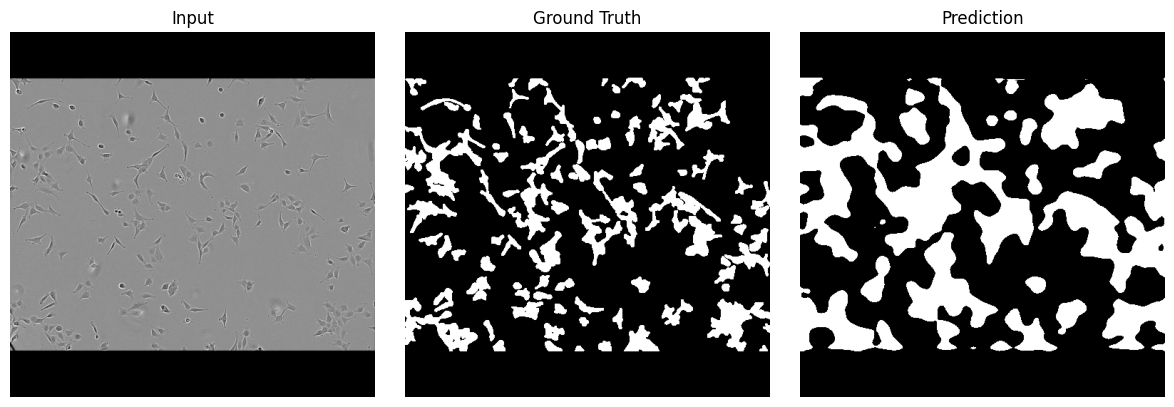

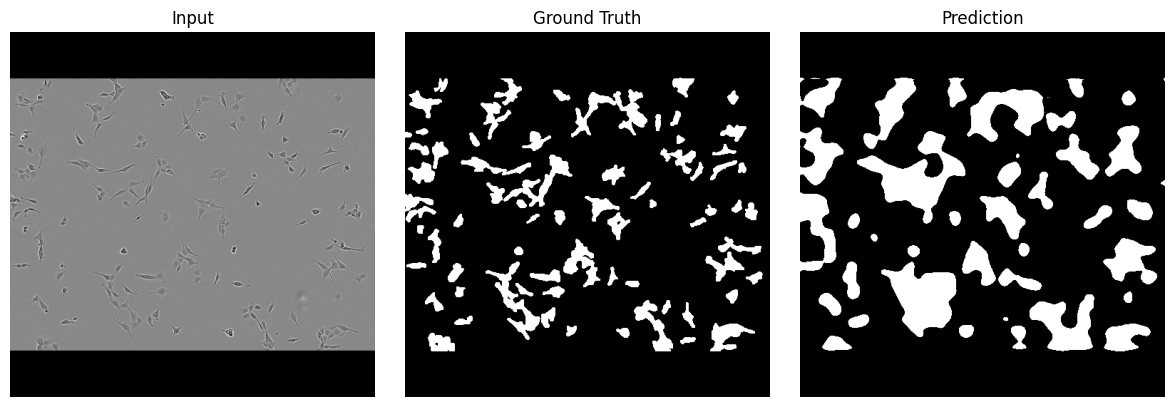

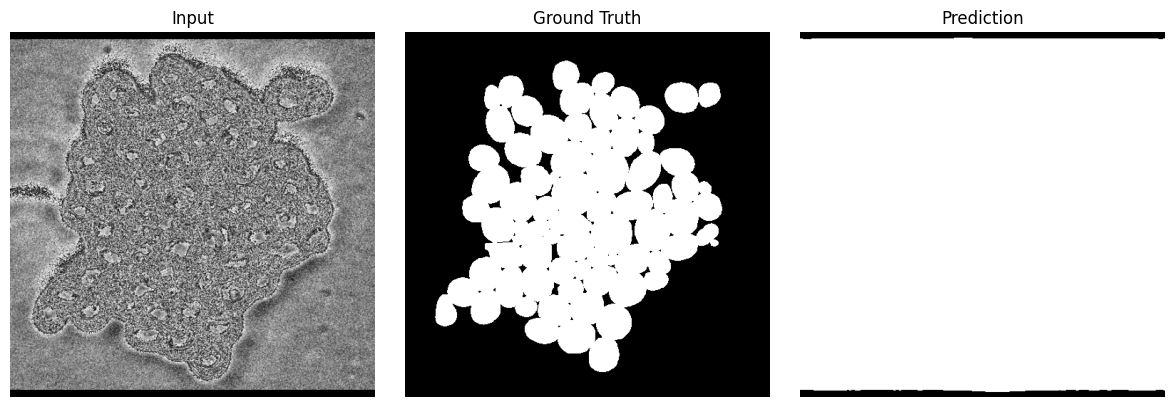

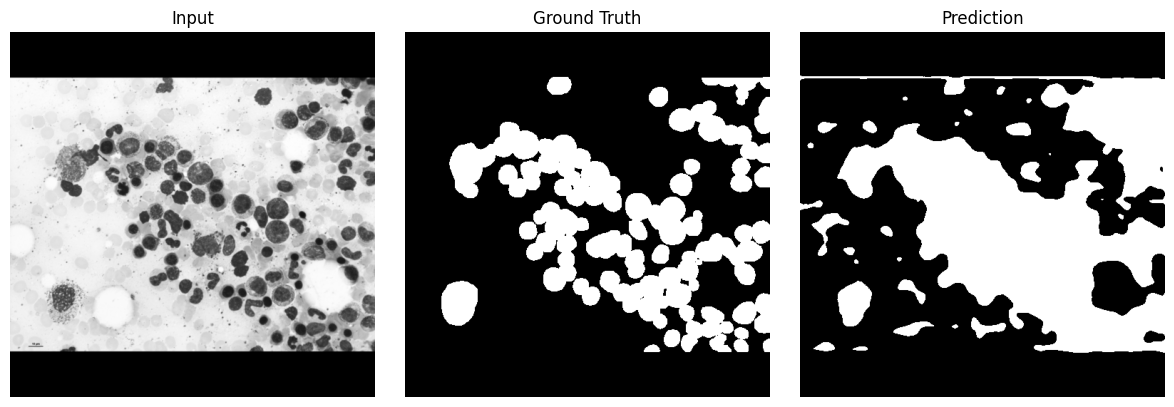

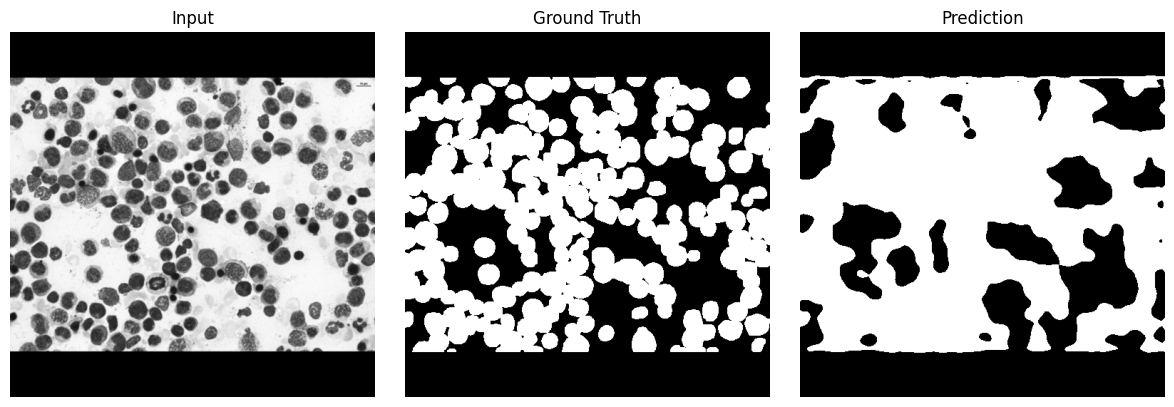

Testing Residual Attention U-Net:
Test Accuracy: 65.64%

Visualizing predictions for Residual U-Net:


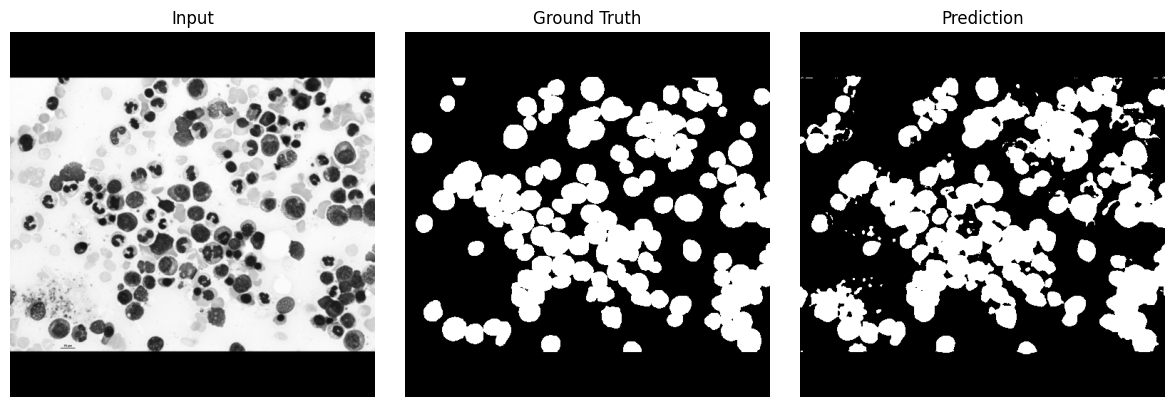

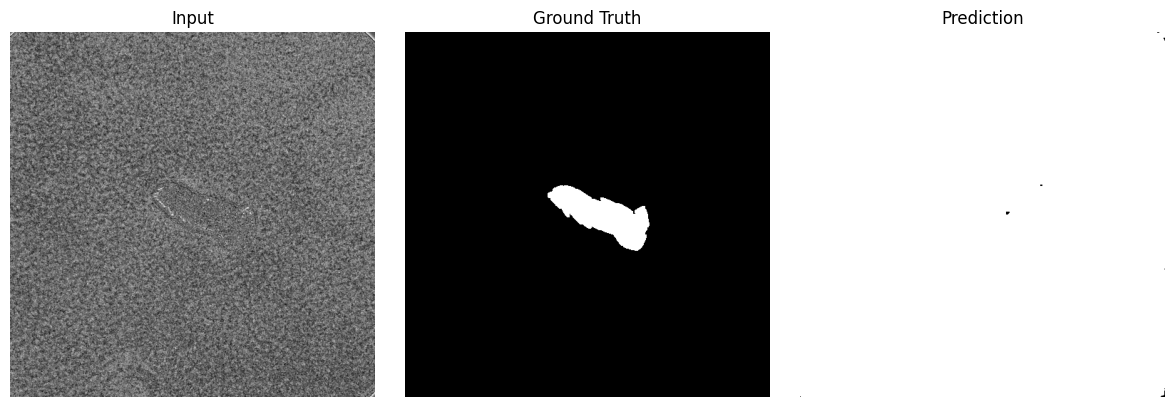

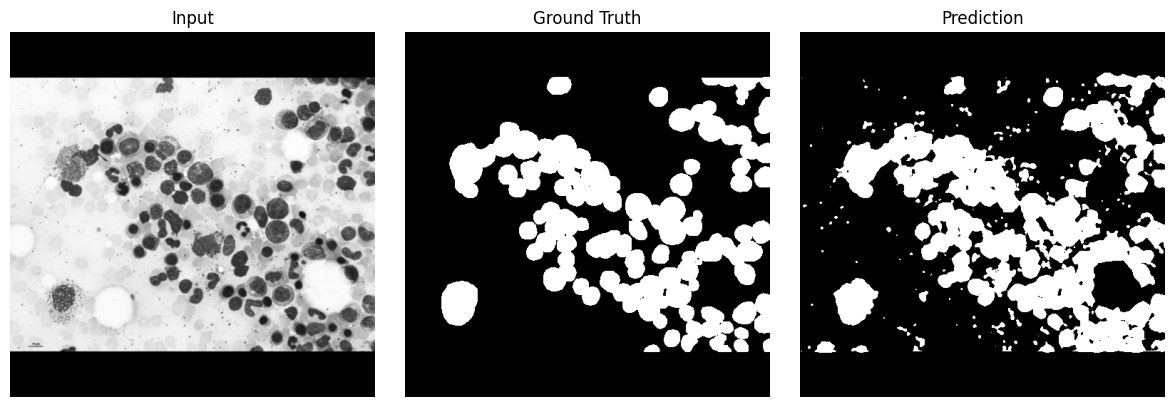

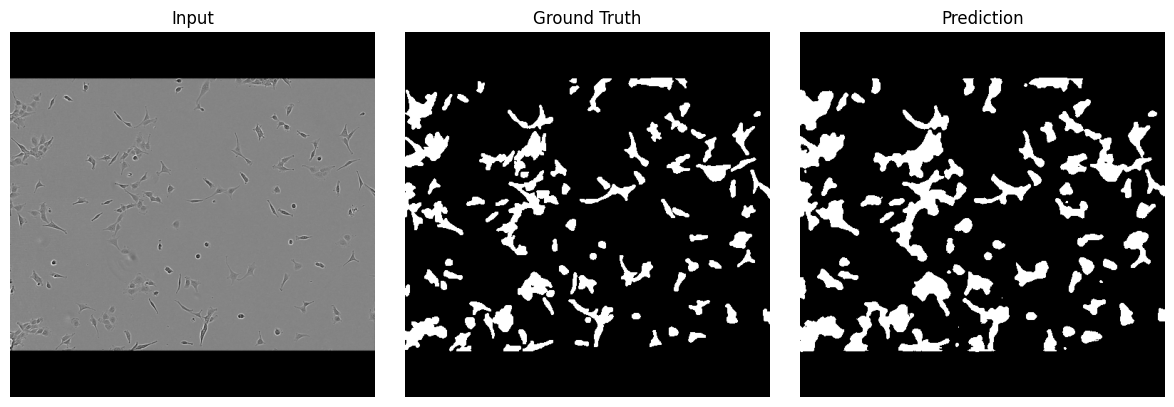

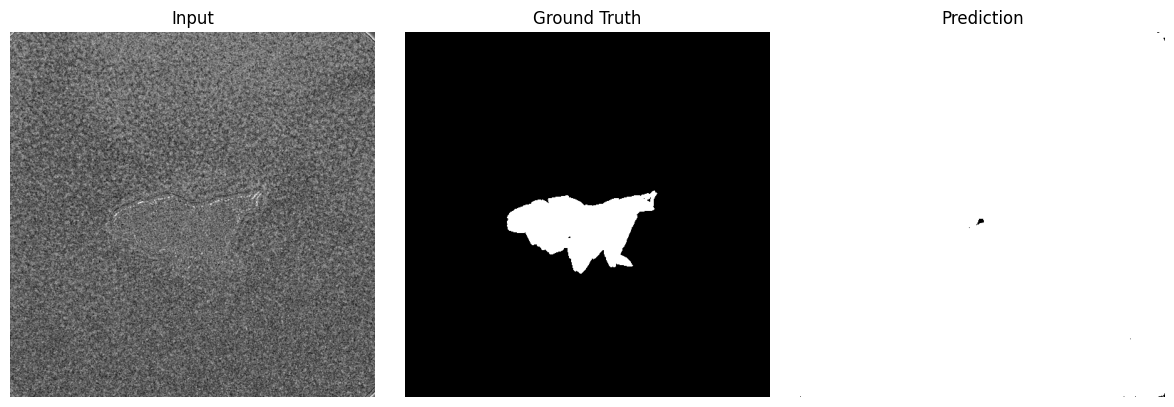


Visualizing attention maps:


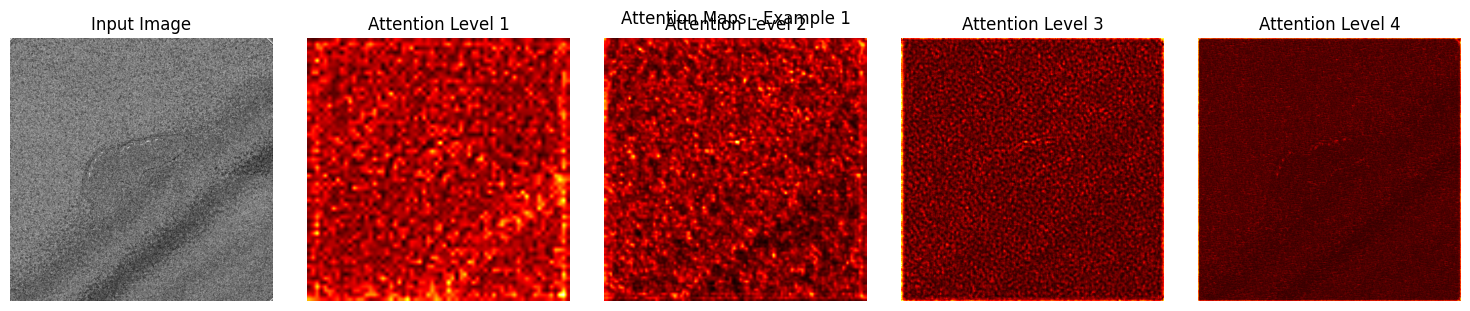

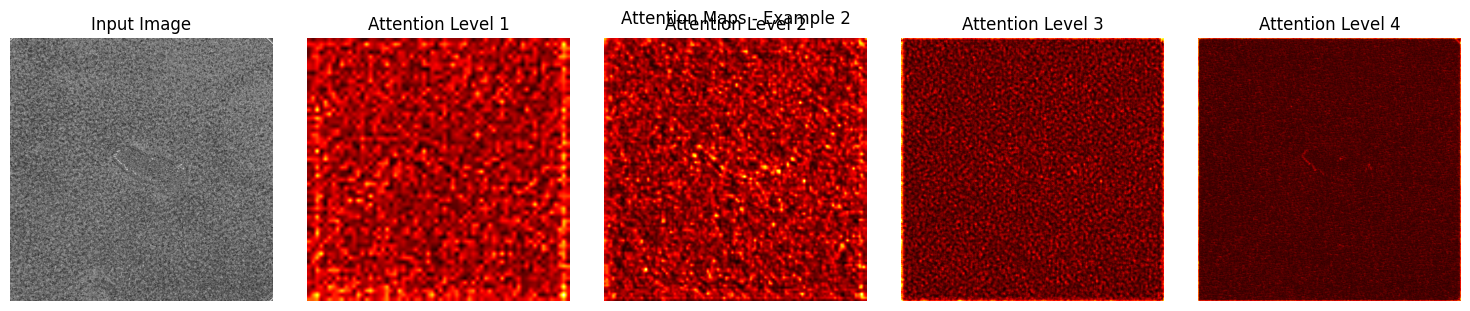

In [108]:
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def test_unet(model, dataloader, device, thresh=THRESHOLD2):
    """
    Test the model and calculate accuracy
    """
    model.eval()
    total_correct = 0
    total_pixels = 0

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = (torch.sigmoid(outputs) > thresh).float()

        total_correct += (preds == masks).sum().item()
        total_pixels += masks.numel()

    acc = 100.0 * total_correct / total_pixels
    print(f"Test Accuracy: {acc:.2f}%")
    return acc

@torch.no_grad()
def visualize_predictions(model, dataloader, device, num_examples=3, thresh=THRESHOLD2):
    """
    Visualize model predictions alongside ground truth
    """
    model.eval()
    images, masks = next(iter(dataloader))
    images = images.to(device)
    logits = model(images)
    preds = (torch.sigmoid(logits) > thresh).float()

    for i in range(min(num_examples, images.size(0))):
        img = images[i].cpu()
        mask = masks[i, 0].cpu()
        pred = preds[i, 0].cpu()

        # Handle grayscale vs RGB images
        if img.shape[0] == 1:
            img_show = img[0]
            cmap = "gray"
        else:
            img_show = img.permute(1, 2, 0)
            cmap = None

        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(img_show, cmap=cmap)
        ax[0].set_title("Input")
        ax[1].imshow(mask, cmap="gray")
        ax[1].set_title("Ground Truth")
        ax[2].imshow(pred, cmap="gray")
        ax[2].set_title("Prediction")

        for a in ax:
            a.axis("off")

        plt.tight_layout()
        plt.show()

@torch.no_grad()
def visualize_attention_maps(model, dataloader, device, num_examples=2):
    """
    Visualize attention maps from the Residual Attention U-Net
    This function shows what regions the model is focusing on
    """
    model.eval()
    images, masks = next(iter(dataloader))
    images = images[:num_examples].to(device)

    attention_maps = []

    def hook_fn(module, input, output):
        attention_maps.append(output.cpu())

    hooks = []
    for i, attn_block in enumerate(model.attention_blocks):
        hook = attn_block.register_forward_hook(hook_fn)
        hooks.append(hook)

    _ = model(images)

    for hook in hooks:
        hook.remove()

    for img_idx in range(min(num_examples, images.size(0))):
        fig, axes = plt.subplots(1, len(attention_maps) + 1, figsize=(15, 3))

        img = images[img_idx].cpu()
        if img.shape[0] == 1:
            axes[0].imshow(img[0], cmap='gray')
        else:
            axes[0].imshow(img.permute(1, 2, 0))
        axes[0].set_title('Input Image')
        axes[0].axis('off')

        for i, attn_map in enumerate(attention_maps):
            if img_idx < attn_map.size(0):
                attn = attn_map[img_idx].mean(dim=0)

                attn_resized = torch.nn.functional.interpolate(
                    attn.unsqueeze(0).unsqueeze(0),
                    size=img.shape[-2:],
                    mode='bilinear',
                    align_corners=False
                ).squeeze()

                axes[i+1].imshow(attn_resized, cmap='hot')
                axes[i+1].set_title(f'Attention Level {i+1}')
                axes[i+1].axis('off')

        plt.tight_layout()
        plt.suptitle(f'Attention Maps - Example {img_idx+1}', y=1.02)
        plt.show()

@torch.no_grad()
def compare_models(model1, model2, dataloader, device, model1_name="Model 1", model2_name="Model 2", num_examples=3, thresh=THRESHOLD):
    """
    Compare predictions from two models side by side
    """
    model1.eval()
    model2.eval()

    images, masks = next(iter(dataloader))
    images = images.to(device)

    logits1 = model1(images)
    logits2 = model2(images)

    preds1 = (torch.sigmoid(logits1) > thresh).float()
    preds2 = (torch.sigmoid(logits2) > thresh).float()

    for i in range(min(num_examples, images.size(0))):
        img = images[i].cpu()
        mask = masks[i, 0].cpu()
        pred1 = preds1[i, 0].cpu()
        pred2 = preds2[i, 0].cpu()

        if img.shape[0] == 1:
            img_show = img[0]
            cmap = "gray"
        else:
            img_show = img.permute(1, 2, 0)
            cmap = None

        fig, ax = plt.subplots(1, 4, figsize=(16, 4))
        ax[0].imshow(img_show, cmap=cmap)
        ax[0].set_title("Input")
        ax[1].imshow(mask, cmap="gray")
        ax[1].set_title("Ground Truth")
        ax[2].imshow(pred1, cmap="gray")
        ax[2].set_title(f"{model1_name} Prediction")
        ax[3].imshow(pred2, cmap="gray")
        ax[3].set_title(f"{model2_name} Prediction")

        for a in ax:
            a.axis("off")

        plt.tight_layout()
        plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Testing Basic U-Net:")
test_accuracy = test_unet(model_basic, dataloader_test, device)

print("\nVisualizing predictions for basic U-Net:")

visualize_predictions(model_basic, dataloader_test, device, num_examples=5)

print("Testing Residual Attention U-Net:")
test_accuracy = test_unet(model_residual, dataloader_test, device)

print("\nVisualizing predictions for Residual U-Net:")
visualize_predictions(model_residual, dataloader_test, device, num_examples=5)

print("\nVisualizing attention maps:")
visualize_attention_maps(model_residual, dataloader_test, device, num_examples=2)

## FINE-TUNING


In [111]:
print("\nStarting finetuning for basic UNet...")
for epoch in range(1, num_epochs + 1):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"{'='*50}")

    train(model_basic, device, dataloader_val, optimizer, epoch, log_interval)

print("\nStarting finetuning for Residual UNet...")
for epoch in range(1, num_epochs + 1):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"{'='*50}")

    train(model_residual, device, dataloader_val, optimizer, epoch, log_interval)


Starting finetuning for basic UNet...

Epoch 1/20
Train Epoch: 1 [0/58 (0%)]	Loss: 0.237285
Train Epoch: 1 [50/58 (83%)]	Loss: 0.276695
Train Epoch: 1 Average loss: 0.386105, Accuracy: 83.92%

Epoch 2/20
Train Epoch: 2 [0/58 (0%)]	Loss: 0.429379
Train Epoch: 2 [50/58 (83%)]	Loss: 0.286461
Train Epoch: 2 Average loss: 0.442439, Accuracy: 82.54%

Epoch 3/20
Train Epoch: 3 [0/58 (0%)]	Loss: 0.208909
Train Epoch: 3 [50/58 (83%)]	Loss: 0.236483
Train Epoch: 3 Average loss: 0.346616, Accuracy: 84.55%

Epoch 4/20
Train Epoch: 4 [0/58 (0%)]	Loss: 0.624857
Train Epoch: 4 [50/58 (83%)]	Loss: 0.480573
Train Epoch: 4 Average loss: 0.420751, Accuracy: 83.59%

Epoch 5/20
Train Epoch: 5 [0/58 (0%)]	Loss: 0.293881
Train Epoch: 5 [50/58 (83%)]	Loss: 0.532483
Train Epoch: 5 Average loss: 0.412856, Accuracy: 83.53%

Epoch 6/20
Train Epoch: 6 [0/58 (0%)]	Loss: 0.598338
Train Epoch: 6 [50/58 (83%)]	Loss: 0.449464
Train Epoch: 6 Average loss: 0.436480, Accuracy: 83.39%

Epoch 7/20
Train Epoch: 7 [0/58 (0%)


Finetuning results...
Testing Basic U-Net:
Test Accuracy: 61.07%
Test set: Average loss: 0.6388, Accuracy: 61.52%, f1: 0.5211, Recall: 0.8930, Precision: 0.3678
AP@0.5 0.3390 IoU 0.4646

Visualizing predictions for basic U-Net:


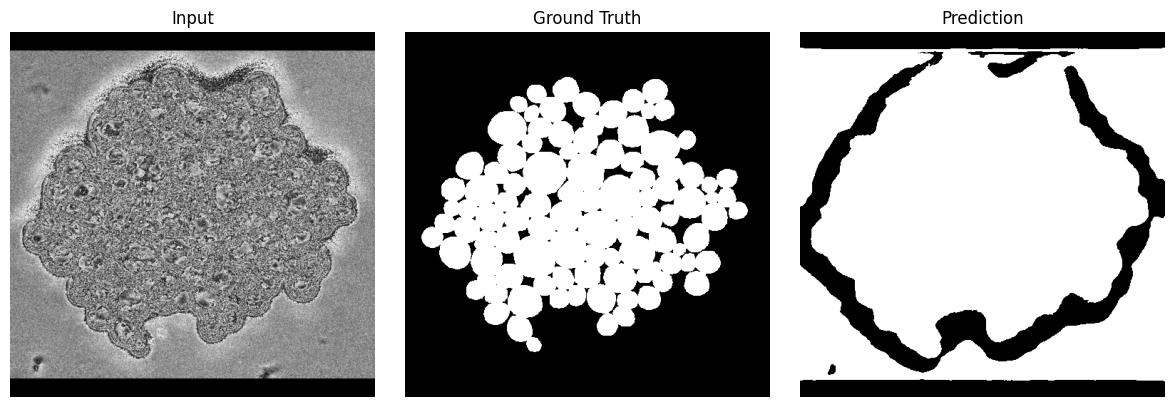

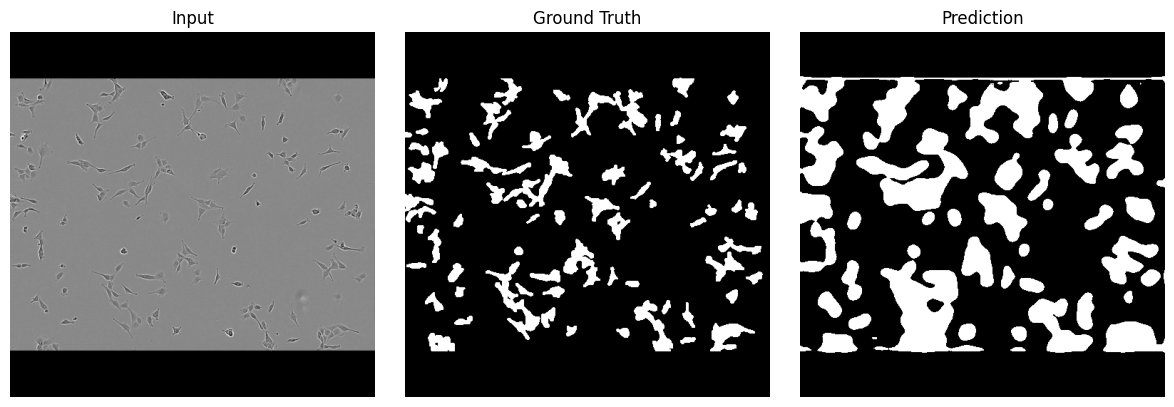

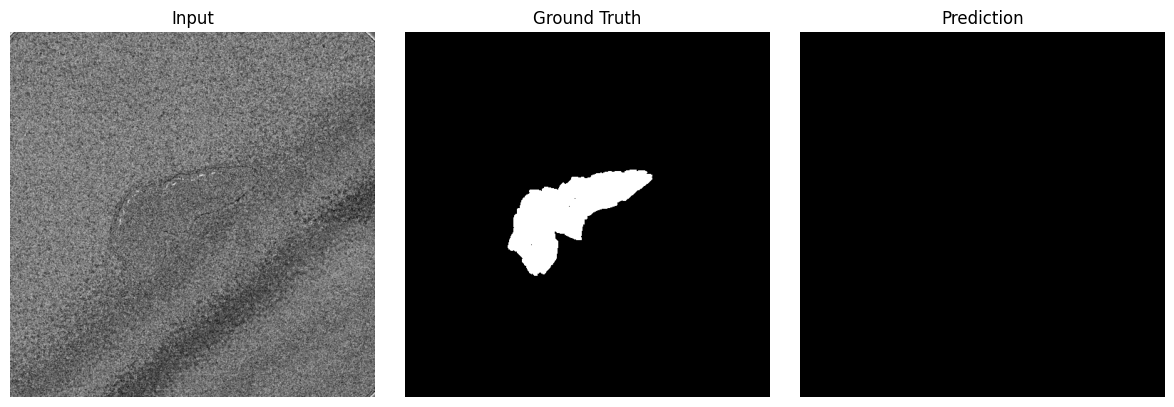

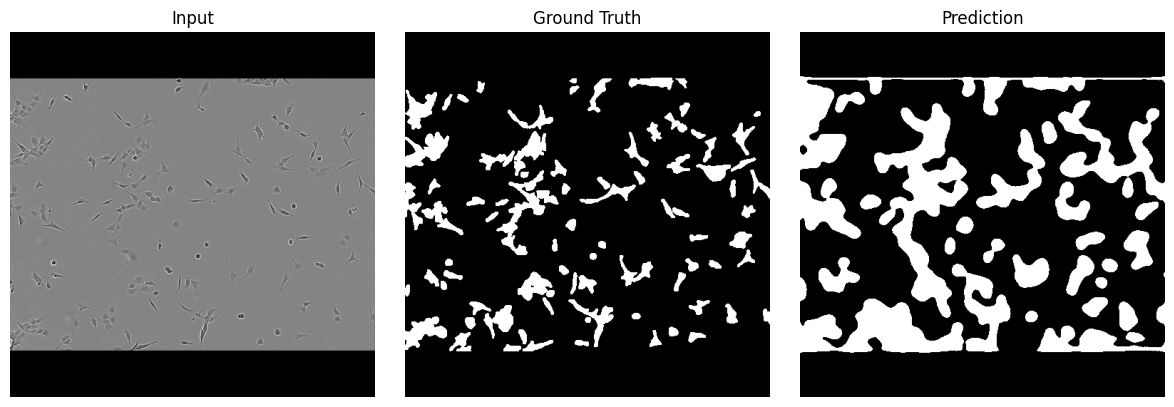

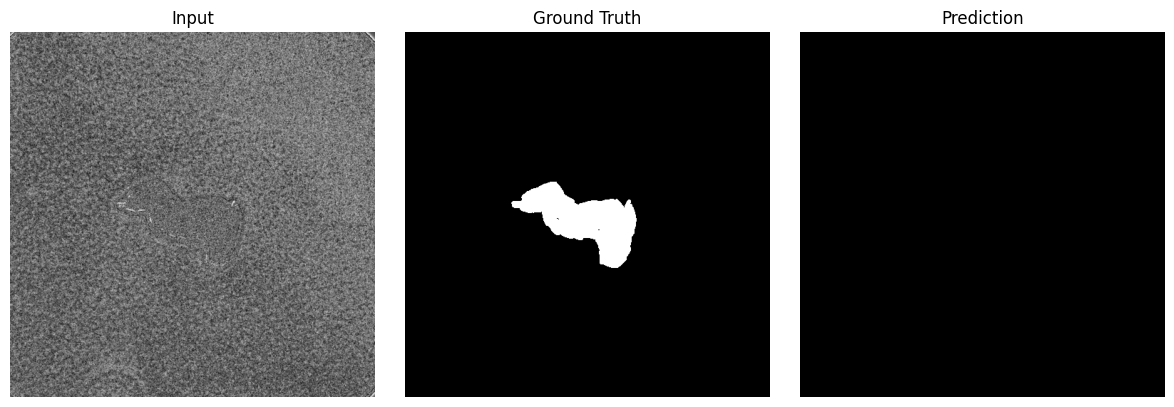

Testing Residual Attention U-Net:
Test Accuracy: 65.64%
Test set: Average loss: 0.6870, Accuracy: 66.24%, f1: 0.5669, Recall: 0.9426, Precision: 0.4053
AP@0.5 0.4723 IoU 0.5564

Visualizing predictions for Residual U-Net:


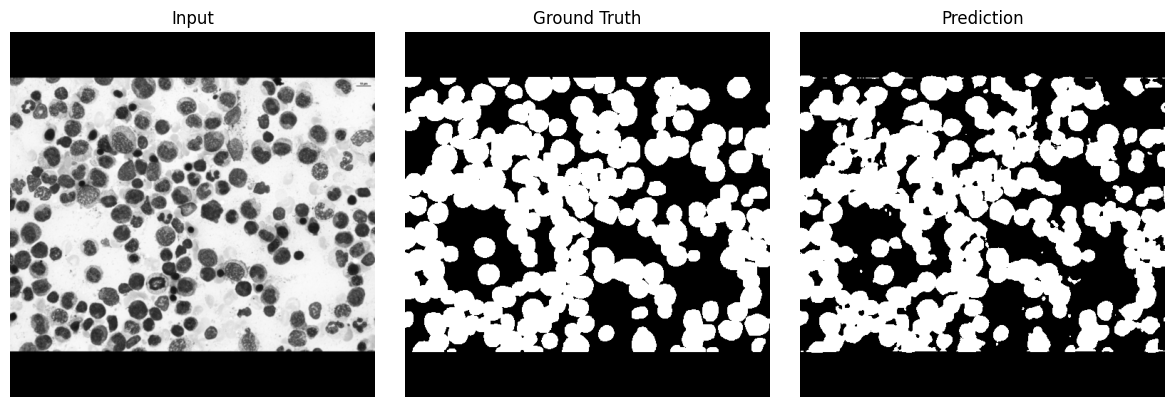

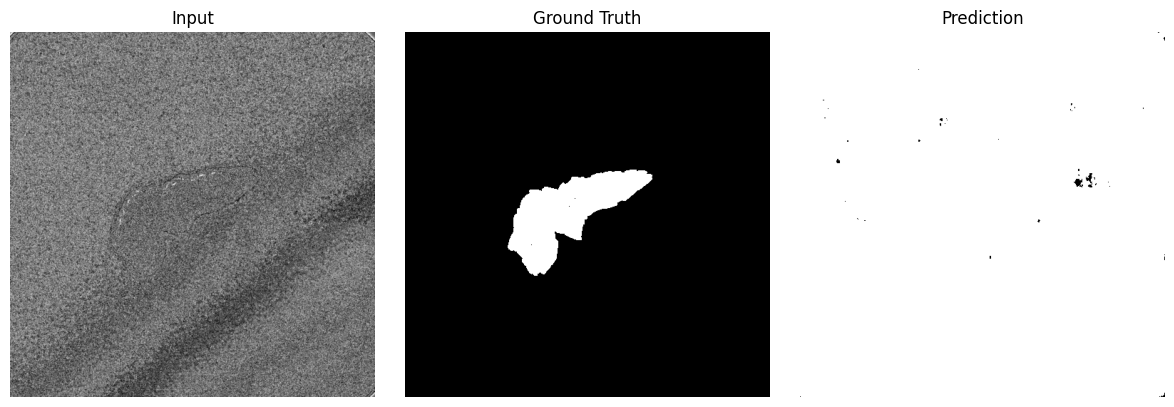

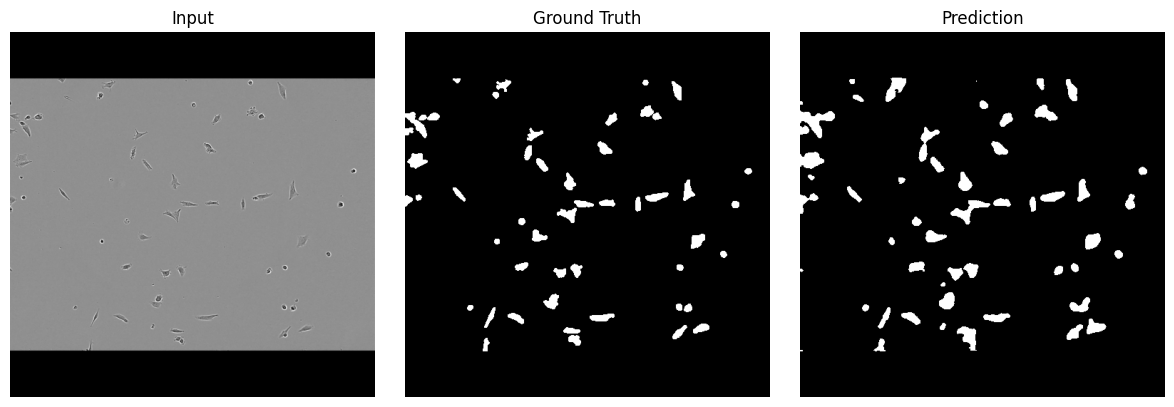

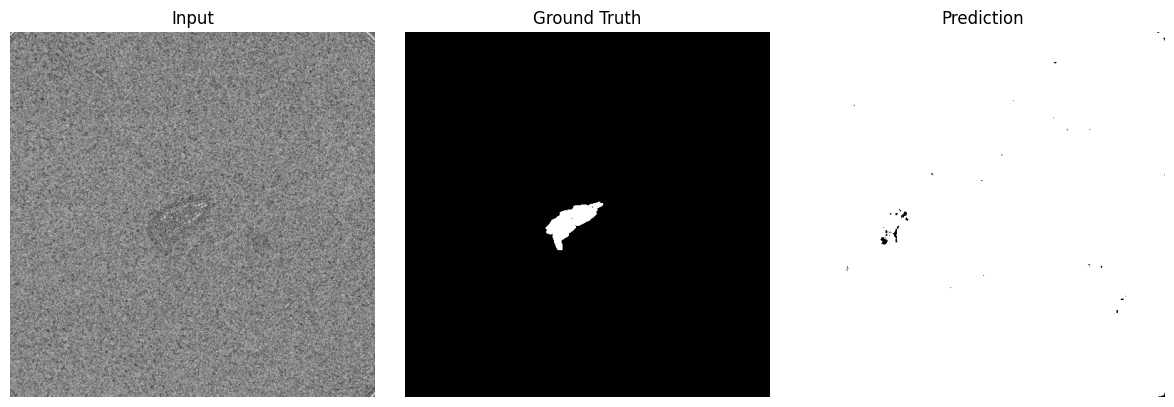

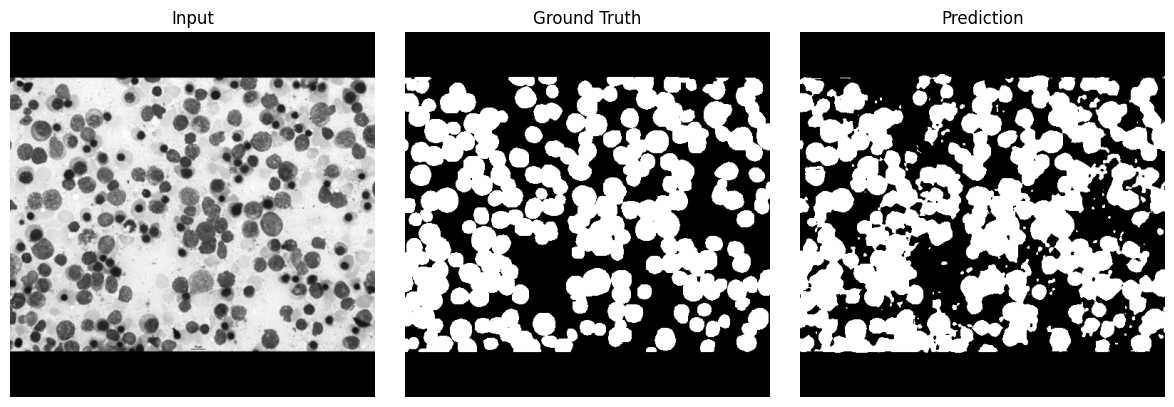


Visualizing attention maps:


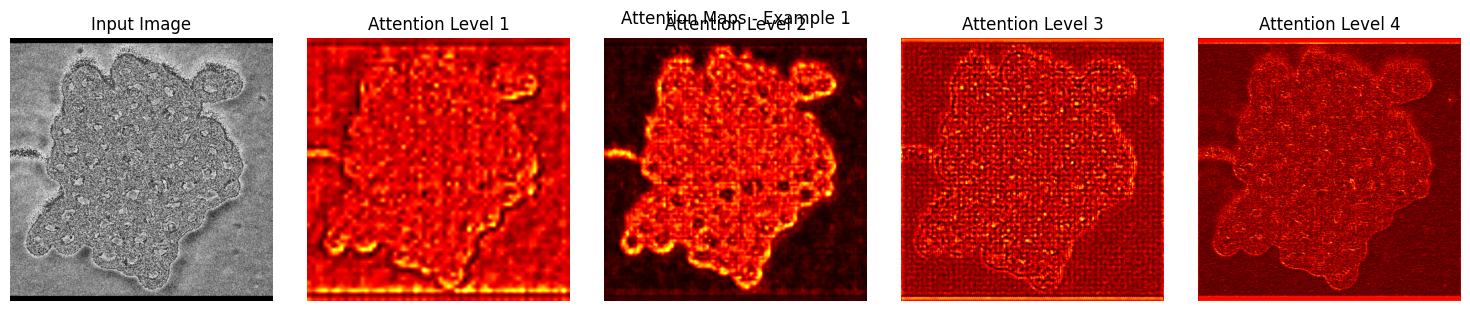

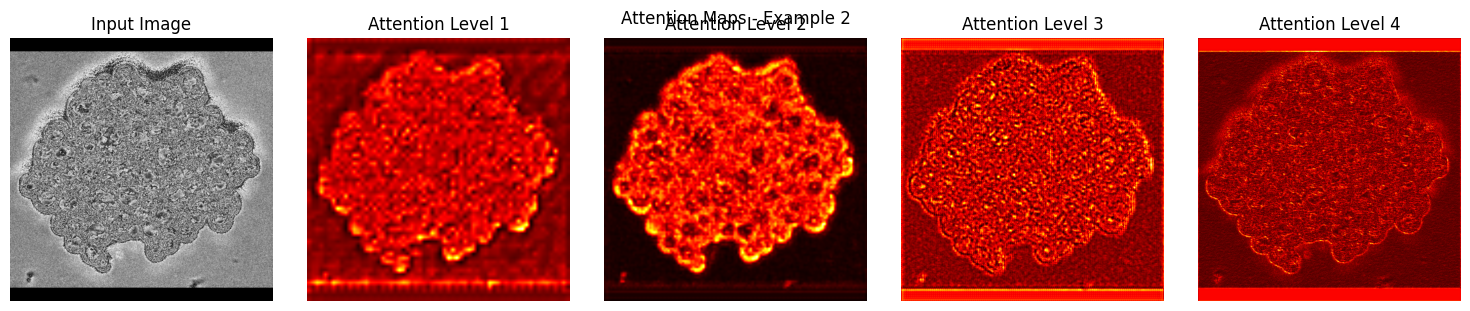

In [113]:
print("\nFinetuning results...")

print("Testing Basic U-Net:")
test_accuracy = test_unet(model_basic, dataloader_test, device)
test(model_basic, device, dataloader_test)

print("\nVisualizing predictions for basic U-Net:")

visualize_predictions(model_basic, dataloader_test, device, num_examples=5)

print("Testing Residual Attention U-Net:")
test_accuracy = test_unet(model_residual, dataloader_test, device)
test(model_residual, device, dataloader_test)

print("\nVisualizing predictions for Residual U-Net:")
visualize_predictions(model_residual, dataloader_test, device, num_examples=5)

print("\nVisualizing attention maps:")
visualize_attention_maps(model_residual, dataloader_test, device, num_examples=2)